# Accessing OOI Endurance Array Surface Mooring Dissolved Oxygen Data

There are six surface moorings in the OOI Endurance Array (EA), each with a dissolved oxygen (DO) sensor at 7 m depth on a midwater platform, termed the Near Surface Instrument Frame (NSIF). Four of the EA surface moorings have DO sensors on seafloor platforms, termed the Multifunction Node (MFN). The MFNs sit directly on the seafloor and the DO sensors are mounted approximately 1 m above the seafloor. The DO data available is a function of the data logger used (either a Data Concentrator Logger, DCL, or an SBE 16Plus V2 SeaCat CTD). DCL logged data includes the calibrated phase and optode thermistor temperature data that can be used to recompute the DO concentrations. The table below indicates which loggers are used at the different sites and platforms. Note, DO sensors for the Oregon Shelf and Offshore sites are mounted on the Cabled Array Benthic Experiment Package (BEP) seafloor platforms. Data from those sensors is not covered here. 

| Mooring | Site Name | NSIF Logger | Seafloor Logger and Site Depth |
| --- | --- | --- | --- |
| CE01ISSM | Oregon Inshore Surface Mooring | CTD | CTD, 25 m |
| CE02SHSM | Oregon Shelf Surface Mooring | DCL | Cabled Array BEP, 80 m |
| CE04OSSM | Oregon Offshore Surface Mooring | DCL | Cabled Array BEP, 582 m |
| CE06ISSM | Washington Inshore Surface Mooring | CTD | CTD, 29 m |
| CE07SHSM | Washington Shelf Surface Mooring | DCL | CTD, 87 m |
| CE09OSSM | Washington Offshore Surface Mooring | DCL | CTD, 542 m |

In [1]:
import datetime
import os

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

from ooi_data_explorations.common import list_deployments, get_deployment_dates, get_vocabulary, m2m_request, \
    m2m_collect, update_dataset, CONFIG, ENCODINGS
from ooi_data_explorations.uncabled.process_dosta import dosta_ctdbp_datalogger, dosta_datalogger

import warnings
warnings.filterwarnings('ignore')

### Requesting Washington Inshore and Shelf Summer 2020 Data 

This notebook will focus on requesting, downloading and plotting data from the Washington Inshore (CE06ISSM) and Shelf (CE07SHSM) Surface moorings since June 1, 2020. The methods shown, however, are applicable to any of the EA surface moorings or the OOI Pioneer and Global Arrays.

### Structuring the Data Request

I will be using the python code in the [OOI Data Explorations Repository](https://github.com/oceanobservatories/ooi-data-explorations) to request, download and process the DO data for this notebook. A README is [available](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/README.md) to describe to how to install, setup and use this python code. A [detailed description](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/README.md#m2m-terminology) of the elements needed to structure the request is available as a part of that [README](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/README.md).

In [2]:
# Setup needed parameters for the request for CE06ISSM
site = 'CE06ISSM'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '03-DOSTAD000'     # OOI Net sensor designator
stream = 'dosta_abcdjm_ctdbp_dcl_instrument'  # OOI Net stream name
method = 'telemetered'      # OOI Net data delivery method

# Set the start date to June 1, 2020. Leaving the stop date empty will request through the end of the record.
start = '2020-06-01T00:00:00.000Z'    # explicit date/time format required for M2M requests

# request the data
r = m2m_request(site, node, sensor, method, stream, start)

Requesting:
	refdes: CE06ISSM-RID16-03-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_ctdbp_dcl_instrument
	from 2020-06-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [01:32<00:00,  4.31it/s]


### Results of the Data Request

The data request structured and executed above does not actually return any data. Instead, we receive an email with a link to a THREDDS catalog that has NetCDF files containing the results of the requests. We also will receive a JSON formatted response to the request that contains all the information needed to access the data directly. In this case, the response is in the variable `r`.

The URL of the THREDDS catalog is contained in both `r.outputURL` and `r.allURLs`. You can copy/paste those into a browser and see the catalog. If you alter the URL slightly, removing everything in between your email address and `catalog.html`, you will have access to all of your requested catalogs (kept for approximately 6 months). If you want to re-download a dataset, you can simply go back to your catalog and find the request of interest rather than issuing a new request for the data.

There will be several files in the catalog. We are specifically after the NetCDF files, or the `*.nc` files. If data from another instrument was required to process the data, those files we also be present. The use of a simple regex search term will allow us to collect and download only the NetCDF data of interest for this instrument.

In [3]:
# collect and download the DOSTA data from the NSIF in an xarray dataset
nsif06 = m2m_collect(r, '.*DOSTA.*\\.nc$')

Waiting: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


The steps above were a bit verbose. Lets get the rest of the data for the CE06ISSM MFN as well as for CE07SHSM. Note the CE07SHSM is a DCL logged data set, so the parameters used for the request are different. All the data will be in xarray datasets.

In [4]:
# CE06ISSM MFN
r = m2m_request(site, 'MFD37', sensor, method, stream, start)
mfn06 = m2m_collect(r, '.*DOSTA.*\\.nc$')

# CE07SHSM NSIF
r = m2m_request('CE07SHSM', 'RID27', '04-DOSTAD000', method, 'dosta_abcdjm_dcl_instrument', start)
nsif07 = m2m_collect(r, '.*DOSTA.*\\.nc$')

# CE07SHSM MFN
r = m2m_request('CE07SHSM', 'MFD37', sensor, method, stream, start)
mfn07 = m2m_collect(r, '.*DOSTA.*\\.nc$')

Requesting:
	refdes: CE06ISSM-MFD37-03-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_ctdbp_dcl_instrument
	from 2020-06-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]
Requesting:
	refdes: CE07SHSM-RID27-04-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_dcl_instrument
	from 2020-06-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 2/2 [04:28<00:00, 134.31s/it]
Requesting:
	refdes: CE07SHSM-MFD37-03-DOSTAD000
	method: telemetered
	stream: dosta_abcdjm_ctdbp_dcl_instrument
	from 2020-06-01T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


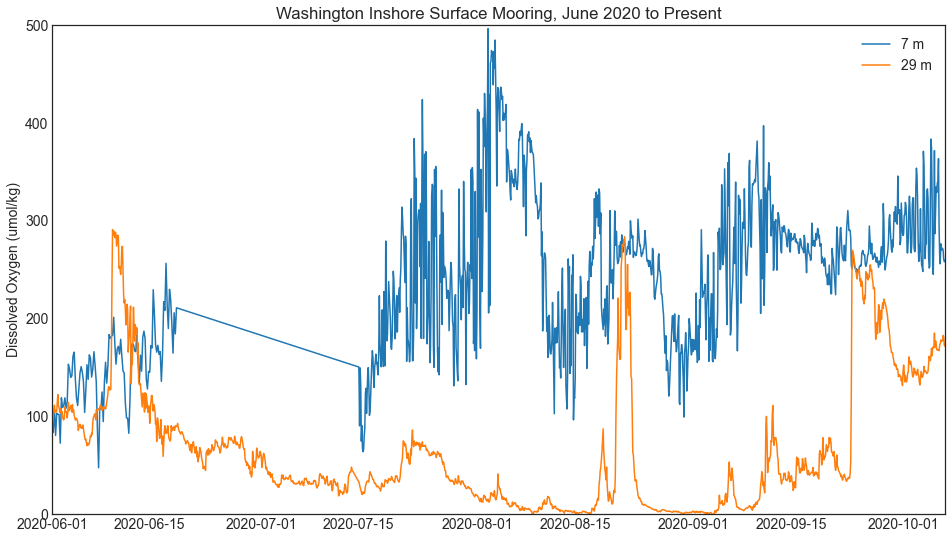

In [7]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.plot(nsif06.time, nsif06.dissolved_oxygen, label='7 m')
plt.plot(mfn06.time, mfn06.dissolved_oxygen, label='29 m')
plt.title('Washington Inshore Surface Mooring, June 2020 to Present')
plt.ylabel('Dissolved Oxygen (umol/kg)')
plt.xlim(datetime.date(2020, 6, 1), datetime.date(2020, 10, 7))
plt.ylim(0, 500)
plt.legend()
plt.show()

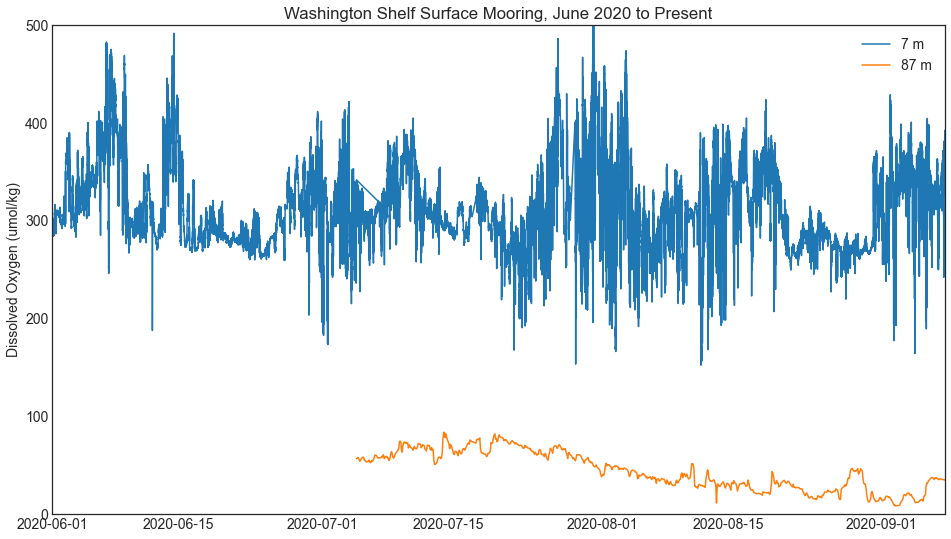

In [8]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
plt.plot(nsif07.time, nsif07.dissolved_oxygen, label='7 m')
plt.plot(mfn07.time, mfn07.dissolved_oxygen, label='87 m')
plt.title('Washington Shelf Surface Mooring, June 2020 to Present')
plt.ylabel('Dissolved Oxygen (umol/kg)')
plt.xlim(datetime.date(2020, 6, 1), datetime.date(2020, 9, 8))
plt.ylim(0, 500)
plt.legend()
plt.show()

### Saving the Results for Further Analysis

Because the data are in xarray datasets, we can, if so desired, use the `to_netcdf` method to save the results to the local disk for further analysis. 

In [9]:
def save_dosta(ds, site, level, instrmt):
    home = os.path.expanduser('~')
    m2m_base = os.path.abspath(os.path.join(home, 'ooidata/m2m'))
    out_path = os.path.join(m2m_base, site, level, instrmt)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    out_file = ('%s.%s.%s.Summer2020.nc' % (site, level, instrmt))
    nc_out = os.path.join(out_path, out_file)
    ds.to_netcdf(nc_out, mode='w', format='NETCDF4', engine='h5netcdf', encoding=ENCODINGS)

# clean up, update and save the datasets -- CE06ISSM
nsif06 = dosta_ctdbp_datalogger(nsif06)
nsif06 = update_dataset(nsif06, 7)
save_dosta(nsif06, 'ce06issm', 'nsif', 'dosta')
mfn06 = dosta_ctdbp_datalogger(mfn06)
mfn06 = update_dataset(mfn06, 29)
save_dosta(mfn06, 'ce06issm', 'seafloor', 'dosta')

# clean up, update and save the datasets -- CE07SHSM
nsif07 = dosta_datalogger(nsif07, burst=False)
nsif07 = update_dataset(nsif07, 7)
save_dosta(nsif07, 'ce07shsm', 'nsif', 'dosta')
mfn07 = dosta_ctdbp_datalogger(mfn07)
mfn07 = update_dataset(mfn07, 87)
save_dosta(mfn07, 'ce07shsm', 'seafloor', 'dosta')